In [1]:
# physical constants
# new and tidied up version

### AEROSOL GROWTH TRIAL RUN ###
import numpy as np


awat = 17.25
asat = 610.7
t0 = 273.15
r36 = 36.
tiny = 1e-9
rh2o = 460.
rair = 287
rgasair = 287.04
cpair = 1004.64
ps0 = 101325.
rgashum = 460.
cphum = 1870.
cvair = cpair - rgasair
cvhum = cphum - rgashum
latent_heat = 2500800.
cpwat = 4183.
r36 = 36.
r0 = 0.
r1 = 1.
r2 = 2.
r3 = 3.
r4 = 4.
r5 = 5.
r6 = 6.
pi = 3.14


def sat_press_water(temp):
    # returns value in Pa
    awat = 17.25
    t0 = 273.15
    r36 = 36.
    tiny = 1e-9
    asat = 610.7
    expon = awat * (temp - t0) / max(temp - r36, tiny)
    return asat * np.exp(expon)

def liquid_water_supersat_mr(satpw, gasnew, rgas, press_anom):
    # h2ovap is specific humidity aka mixing ratio in kg/kg
    # returns fractional value relative to supersaturation (0=supersaturation!)
    rgashum = 460
    tiny = 1e-9
    ps0 = 101325
    pfak = rgas / (rgashum * (press_anom + ps0)) * gasnew
    satww = satpw * pfak
    return satww

def cbar(temp):
    rt8kovpimh2o = 34.296
    return rt8kovpimh2o * temp**(0.5)

#-------------------#
# gas laws and such #
#------------------ #


def densair(press_anom, rgas, temp):
    p0 = 101325.0
    return (press_anom + p0) / (rgas * temp)


def pressure_to_mixing_ratio(temp, ph2o):
    # calculate gas constant and specific humidity
    rh2o = 460.
    rair = 287.
    p0 = 101325.
    rgas = p0 * rh2o * rair / (p0 * rh2o - ph2o * (rh2o - rair))
    qv = ph2o * rair / (p0 * rh2o - ph2o * (rh2o - rair))
    return qv


def sat_press_water(temp):
    # returns value in Pa
    awat = 17.25
    t0 = 273.15
    r36 = 36.
    tiny = 1e-9
    asat = 610.7
    expon = awat * (temp - t0) / max(temp - r36, tiny)
    return asat * np.exp(expon)


def liquid_water_supersat(satpw, gasnew, rgas, press_anom, h2ovap):
    # h2ovap is specific humidity aka mixing ratio in kg/kg
    # returns fractional value relative to supersaturation (0=supersaturation!)
    tiny = 1e-9
    pfak = rgas / (rgashum * (press_anom + ps0)) * gasnew
    satww = satpw * pfak
    return h2ovap / satww - 1.

#----------------------#
# cloud microphysics   #
#----------------------#


def drop_evap(temp, qv, rgas, gasnew, press_anom):
    # evaporative flux per particle
    heatlat = 4160
    diff_k = 4.0e-2
    diff_d = 2.0e-5
    satpw = sat_press_water(temp)
    supsat = liquid_water_supersat(satpw, gasnew, rgas, press_anom, qv)
    Fk = (heatlat / (rgashum * temp) - 1) * heatlat / (diff_k * temp)
    Fd = rgashum * temp / (diff_d * sat_press_water(temp))
    return supsat / (Fk + Fd)


def cond_evap_mh(cldnum, cldrad, conv, drop_evap_flux):
    return r4*pi*cldnum*cldrad*conv*drop_evap_flux

def kessler_autoconv(qc):
    threshold = 5e-4
    rate = 1e-3
    if qc > threshold:
        return rate * (qc - threshold)
    else:
        return 0


def activated_number_tend(rcrit, Nt, sigma_eff, reff):
    from scipy.special import gammainc, gamma
    rn = reff * sigma_eff
    rcrit=rcrit * sigma_eff
    nu = 1. / sigma_eff - r2
    Nact = Nt * (1.-gammainc(nu, rcrit / rn))
    return Nact


def activated_mass_tend(Nact, sigma_eff, reff):
    rho_cloud = 1000.
    activated_mass = r4 * pi * rho_cloud / 3. * reff**3.
    return activated_mass

#-----------------------#
# size distributions    #
#-----------------------#

def mass_moment(rho_aerosol, Nt, sigma_eff, r_eff):
    rn = r_eff * sigma_eff
    nu = 1 / sigma_eff - r2
    third_moment = Nt * rn**r3 * nu * (nu + r1) * (nu + r2)
    return r4 / r3 * pi * rho_aerosol * third_moment

def calc_reff(rho_aerosol, N, L, sigma_eff):
    nu = 1 / sigma_eff - r2
    # rn=(r3*L/(r4*N*pi*rho_aerosol*nu*(nu+r1)*(nu+r2)))**(r1/r3)
    rn = (r3 * L / (r4 * N * pi * rho_aerosol))**(r1 / r3)
    return rn / sigma_eff

def aerosol_mass_cond_moment_tend(temp, qv, conv, Dn, reff, sigma_eff, Nt):
    Dn = reff * sigma_eff
    nu = 1 / sigma_eff - r2
    rho_aerosol = 1000.  # to be fixed
    alpha_h2o = 1.
    return r3 / r2 * (alpha_h2o * cbar(temp) * rho_aerosol) * qv * Dn**r2 * Nt * nu * (nu + r1) / conv


def kohler_psat(temp, rho_dry, dry_radius, wet_radius):
    # dry radius, wet_radius in m
    # returns saturated pressure in Pa over a surface radius wet_radius
    # given a dry_radius of dry_radius (and mass a/c rho_dry)
    # checks out with R+Y

    # rmm in kg/mol
    rmm = 0.023 + 0.035

    # calculate dry_mass aerosol mass in kg
    dry_mass = 4 / 3 * pi * rho_dry * dry_radius**r3

    # constants for calculation of crit radius
    a = 3.3e-5 / temp             # units cm
    b = 4.3 * r2 * dry_mass / rmm      # units cm3

    wet_radius = wet_radius * 100.  # units cm
    kohler_psat = sat_press_water(temp) * (r1 + a / wet_radius - b / wet_radius**r3)
    if kohler_psat<0:
        return sat_press_water(temp)
    else:
        return kohler_psat


def kappa_kohler_psat(temp, rho_dry, dry_radius, wet_radius):
    # dry radius, wet_radius in m
    # returns saturated pressure in Pa over a surface radius wet_radius
    # given a dry_radius of dry_radius (and mass a/c rho_dry)
    # checks out with R+Y
    kappa = 1.3
    sigma = 0.072
    R = 8.31
    T = temp
    rho_w = 1000.
    rho_dry = 2550.
    Mw = 0.018
    kappa_kohler_psat = sat_press_water(temp) * (wet_radius**r3 - dry_radius**r3) / (
        wet_radius**r3 - dry_radius**r3 * (1 - kappa)) * np.exp(r4 * sigma * Mw / (R * T * rho_w * wet_radius))
    # if kappa_kohler_psat<=0:
    #    return sat_press_water(temp)
    # else:
    return kappa_kohler_psat


def crit_radius(temp, rho_initial, reff_initial, reff, rho):
    # dry mass input in kg
    # rmm in g/mol
    # returns crit radius in m (checked!)

    rmm = 0.023 + 0.035

    # convert dry_mass input to g for calculation
    dry_mass = r4 / r3 * pi * rho_initial * reff_initial**r3

    # constants for calculation of crit radius
    a = 3.3e-5 / temp
    b = 4.3 * 2 * dry_mass / rmm

    # do calculation
    return 1e-2 * (3 * b / a)**(0.5)



In [104]:
p0=101325. ; relh=0.9995 ; temp=298.
rho_dry=2550
rho_aerosol=1200
reff_initial=10e-9  # m
sigma_eff=0.3      # dimless 
Naer=1e3*1e6
rho_cloud=1000
temp_tend_initial=-0.1

# pretend the box doesn't rise (for now)
press_anom=0.

# model setup
ph2o=relh*sat_press_water(298.)
rgas=p0*rh2o*rair/(p0*rh2o-ph2o*(rh2o-rair))
qv=ph2o*rair/(p0*rh2o-ph2o*(rh2o-rair))

reff_0=reff_initial*1.01 #(HGF at 80% RH)
reff=reff_0
Laer=mass_moment(rho_aerosol, Naer, sigma_eff, reff)
temp_tend=-0.001
reff_cloud=1.0e-6
rdry_cloud=reff_0
Nc=0 ; Lc=0 ; Lr=0
# 1 - gas phase water
# 2 - aerosol numberliquid_water_supersat(sat_press_water(297), 1, rgashum, 0, 1.58e-2)
# 3 - aerosol mass
# 4 - cloud numer
# 5 - cloud mass
# 6 - rain mass
C0 = [qv, Naer, Laer, Nc, Lc, Lr, temp]
args = [temp_tend, reff_cloud, rho_aerosol, reff_initial, reff_initial, rho_aerosol]

In [105]:
Laer

1.4493450227200003e-12

In [136]:
def calc_tend(t, state, args):
    # variables to be used
    qv, Na, La, Nc, Lc, Lr, temp = state
    # anciliary quanities used here
    temp_tend, rcloud, rho_initial, reff_initial, reff, rho =  args

    # generate the cloud effective radius
    if (Nc>0. and Lc>0.):
        rcloud = (3.*Lc / (4.*Nc*pi*1000.))**(1./3.)
    
    # calculate gas mixing ratio
    gasnew=r1-Lc-Lr
    drynew=r1-qv
    conv=gasnew/densair(0, rair, temp)
    
    # generate the specific heats of the gas mixture
    cp=cpair*(r1-qv)+cphum*qv
    cv=cvair*(r1-qv)+cvhum*qv
    rgas=cp-cv
    
    # calculate RH
    ps=sat_press_water(temp)
    qs=pressure_to_mixing_ratio(temp,ps)
    SS=qv/qs   

    aerosol_cond_mass_tend = r0
    aerosol_act_mass_tend = r0

    # expressions not in use - for reference only
    ###aerosol_cond_mass_tend = rdep_aerosol_mass_cond_moment_tend(temp, qv, conv, reff_initial,  reff, sigma_eff, Naer)
    ###aerosol_act_mass_tend=Laer-4/3*pi*rho_aerosol*third_moment_cotton_gamma(Nact, sigma_eff, rcrit)

    # cloud condensational growth
    if (Nc >0):
        drop_evap_flux = drop_evap(temp, qv, rgas, gasnew, press_anom)
        cloud_cond_tend = cond_evap_mh(Nc, rcloud, conv, drop_evap_flux)
        # damping terms
        if cloud_cond_tend > qv:
            cloud_cond_tend = qv
        if cloud_cond_tend < -Lc:
            cloud_cond_tend = -Lc
            temp_tend = temp_tend + (cloud_cond_tend * latent_heat/cv)*10.
    else:
        cloud_cond_tend =0

    # calculate activation?
    if SS<1.:
        Nact = 0.
        cloud_act_mass_tend = r0

    else:
        # calculate activated number
        rcrit = crit_radius(temp, rho_initial, reff_initial, reff, rho)
        Nact  = Naer*0.001
        # calculate cloud activated mass tendency        
        cloud_act_mass_tend = activated_mass_tend(Nact, sigma_eff, rcrit)
        temp_tend = temp_tend+cloud_act_mass_tend*latent_heat/cv

    dqv = -cloud_cond_tend
    dNa = -Nact
    dLa = 0.# aerosol_cond_mass_tend-aerosol_act_mass_tend
    dNc = Nact
    dLc = cloud_act_mass_tend + cloud_cond_tend - kessler_autoconv(Lc)
    dLr = kessler_autoconv(Lc)
    dT = temp_tend
    # return the tendencies in the correct order 
    return [dqv, dNa, dLa, dNc, dLc, dLr,dT]


In [137]:
from scipy.integrate import ode
ts = []
ys = []
t0 = 0.
t1 = 200. # run length 
dt = 0.05 # timestep

# set up system of ODEs and choose integrator, set some tolerances
r = ode(calc_tend).set_integrator('dopri5', method='adams', rtol=5e-3, nsteps=1e3)

# initial values
r.set_initial_value(C0, t0)

# extra values needed for evaluation of tendencies
r.set_f_params(args)

while r.t<t1:
    r.integrate(r.t+dt)
    if r.successful:
        ts.append(r.t)
        ys.append(r.y)

In [138]:
time = ts
ys=np.array(ys)
qv = ys[:,0]
N_aer = ys[:,1]
L_aer = ys[:,2]
N_c = ys[:,3]
L_c = ys[:,4]
L_r = ys[:,5]
temp = ys[:,6]

In [139]:
SS=np.empty_like(temp)
rcloud=np.empty_like(temp)
#generate some diagnostic quantities
for ivar in range(0,len(temp)):
    ps=sat_press_water(temp[ivar])
    qs=pressure_to_mixing_ratio(temp,ps)
    # supersaturation
    SS[ivar]=qv[ivar]/qs 
    # cloud radius
    rcloud[ivar] = (3.*L_c[ivar] / (4.*N_c[ivar]*pi*1000.))**(1./3.)/1e-6

/Users/ptg21/anaconda2/envs/basemap/lib/python2.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in double_scalars
  # Remove the CWD from sys.path while we load stuff.


/Users/ptg21/anaconda2/envs/basemap/lib/python2.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/ptg21/anaconda2/envs/basemap/lib/python2.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/ptg21/anaconda2/envs/basemap/lib/python2.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/Users/ptg21/anaconda2/envs/basemap/lib/python2.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationW

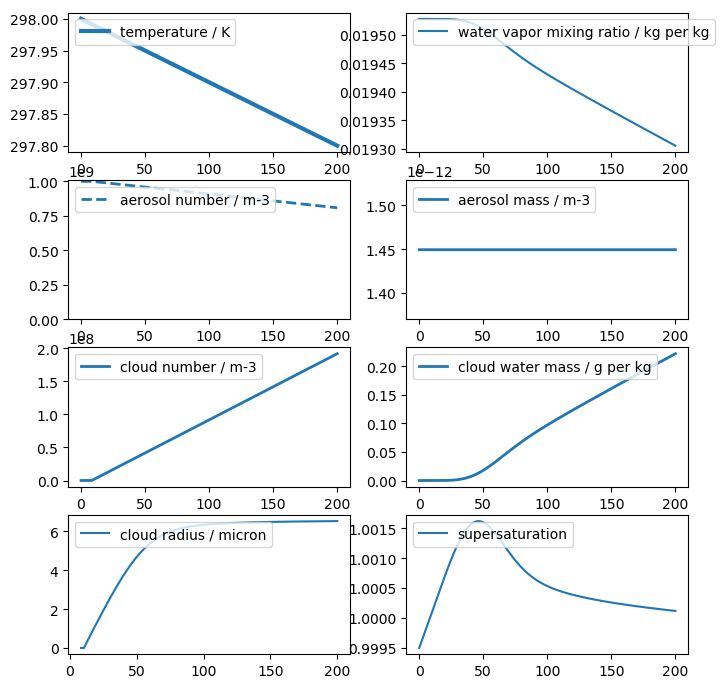

In [140]:
import pylab as P
#import matplotlib.font_manager
#import fpformat as fp
P.figure(figsize=(8,8.5),dpi=100)

P.clf()
P.subplot(421)
P.plot(time, temp,lw=3, label='temperature / K')
P.legend(loc=2)

P.subplot(422)
P.plot(time, qv, label='water vapor mixing ratio / kg per kg')
P.legend(loc=2)

P.subplot(423)
P.plot(time,N_aer, '--', lw=2, label='aerosol number / m-3')
P.ylim(0,1.01e9)
P.legend(loc=2)

P.subplot(424)
P.plot(time,L_aer, lw=2, label='aerosol mass / m-3')
P.legend(loc=2)

P.subplot(425)
P.plot(time,N_c, lw=2, label='cloud number / m-3')
P.legend(loc=2)

P.subplot(426)
P.hold()
P.plot(time,L_c*1e3, lw=2, label='cloud water mass / g per kg')
P.legend(loc=2)

P.subplot(427)
P.hold()
P.plot(time,L_r*1e3, label='rain mass / g per kg')
P.legend(loc=2)

P.subplot(427)
P.hold()
P.plot(time,rcloud, label='cloud radius / micron')
P.legend(loc=2)

P.subplot(428)
P.hold()
P.plot(time,SS, label='supersaturation')
P.legend(loc=2)

P.show()